## Introduction

In this notebook we compare the amplicon distributions from [Lodato et al, 2015](http://science.sciencemag.org/content/350/6256/94.long) and [Zhang et al, 2015](http://www.nature.com/nature/journal/v522/n7555/full/nature14493.html?foxtrotcallback=true)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scipy.optimize
import sys

import PaSDqc

%matplotlib inline

Load the data

In [2]:
p_1465 = "../data/Lodato_2015/1465/psd/"
freq, nd_1465, sl_14165 = PaSDqc.extra_tools.mk_ndarray(p_1465)

In [4]:
p_4638 = "../data/Lodato_2015/4638/psd/"
freq, nd_4638, sl_4638 = PaSDqc.extra_tools.mk_ndarray(p_4638)

In [6]:
p_4643 = "../data/Lodato_2015/4643/psd"
freq, nd_4643, sl_4643 = PaSDqc.extra_tools.mk_ndarray(p_4643)

In [7]:
p_cz = "../data/Zhang_2015/psd/"
freq, nd_cz, sl_cz = PaSDqc.extra_tools.mk_ndarray(p_cz)

In [9]:
f_norm = PaSDqc.extra_tools.get_data_file("bulk_1x.smooth3.spec")
bulk_norm = pd.Series.from_csv(f_norm, index_col=0, sep="\t").as_matrix()

Define fit functions since we're working with array data now

In [10]:
def func_erf(x, inter, asym, mu, sigma):
    return inter + asym * scipy.special.erf((x-mu) / (np.sqrt(2) * sigma))

In [ ]:
def func_erf2(x, inter, asym, mu, sigma):
    return inter + asym * scipy.special.erf((x) / (np.sqrt(2) * sigma))

In [11]:
def fit_curve(freq, nd):
    l_params = []
    freq_cut = freq[freq < 1e-3]
    freq_cut_scale = -np.log10(freq_cut)
    
    for psd in nd:
        psd_mda = 10*np.log10(psd / bulk_norm)
        psd_mda_cut = psd_mda[freq < 1e-3]
        try:
            l_params.append(scipy.optimize.curve_fit(func_erf, freq_cut_scale, psd_mda_cut)[0])
        except:
            pass
        
    return l_params

In [13]:
lp_1465 = fit_curve(freq, nd_1465)
lp_4638 = fit_curve(freq, nd_4638)
lp_4643 = fit_curve(freq, nd_4643[1:, :])
lp_cz = fit_curve(freq, nd_cz)

Fit the Gaussian distributions

In [15]:
def gaussian2(l_params, freq_eval):
    l_pdf = []
    for p in l_params:
        pdf = scipy.stats.norm(loc=p[2], scale=p[3])
        l_pdf.append(pdf.pdf(freq_eval))
        
    return l_pdf

In [16]:
freq_eval = np.arange(3, 5.5, 0.01)
l_pdf_1465 = gaussian2(lp_1465, freq_eval)
l_pdf_4638 = gaussian2(lp_4638, freq_eval)
l_pdf_4643 = gaussian2(lp_4643, freq_eval)

freq_eval2 = np.arange(2.5, 5, 0.01)
l_pdf_cz = gaussian2(lp_cz, freq_eval2)

In [18]:
pdf_alk = np.array(l_pdf_1465+l_pdf_4638+l_pdf_4643)
pdf_alk_avg = np.mean(pdf_alk, axis=0)
pdf_alk_std = np.std(pdf_alk, axis=0)

pdf_cz = np.array(l_pdf_cz)
pdf_cz_avg = np.mean(pdf_cz, axis=0)
pdf_cz_std = np.std(pdf_cz, axis=0)

Save the data

In [32]:
pd.DataFrame(np.array([pdf_alk_avg, pdf_alk_std]).T, columns=['avg', 'std']).to_csv("Ampl_dist_lodato.txt", sep="\t", index=False)
pd.DataFrame(np.array([pdf_cz_avg, pdf_cz_std]).T, columns=['avg', 'std']).to_csv("Ampl_dist_CZ.txt", sep="\t", index=False)

Plot

In [102]:
sns.set_style('ticks', {'ytick.minor.size': 0.0, 'xtick.minor.size': 0.0})
sns.set_context('talk')

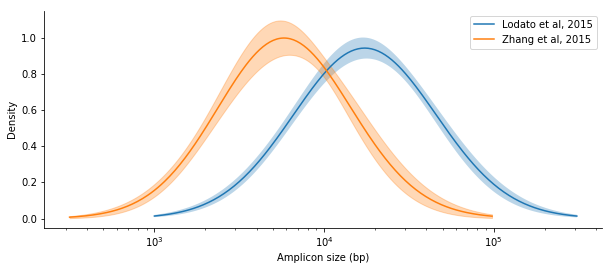

In [35]:
cp = sns.color_palette()
plt.figure(figsize=(10, 4))
plt.plot(10**freq_eval, pdf_alk_avg, label='Lodato et al, 2015')
plt.fill_between(10**freq_eval, pdf_alk_avg-pdf_alk_std, pdf_alk_avg+pdf_alk_std, alpha=0.3)

plt.plot(10**freq_eval2, pdf_cz_avg, label='Zhang et al, 2015')
plt.fill_between(10**freq_eval2, pdf_cz_avg-pdf_cz_std, pdf_cz_avg+pdf_cz_std, alpha=0.3, color=cp[1])
plt.legend()
plt.xscale('log')
plt.xlabel('Amplicon size (bp)')
plt.ylabel('Density')

sns.despine()